In [1]:
from pathlib import Path
from datetime import datetime, timedelta
from dataclasses import dataclass
from typing import *


import polars as pl
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt


ROOT_DIR = Path(os.getcwd()).parent

In [2]:
@dataclass
class PumpEvent:
    pump_id: int
    ticker: str
    time: str
    exchange: str

    def __post_init__(self):
        self.time: pd.Timestamp = pd.Timestamp(self.time)

    def __str__(self):
        return f"Pump event: {self.ticker} - {str(self.time)} on {self.exchange}"

In [3]:
# data is organized by days
pump = PumpEvent(
    pump_id=1, ticker="STMXBTC", time="2020-11-01 18:00:10", exchange="binance"
)

date_range: List[pd.Timestamp] = pd.date_range(
    start=pump.time.round("1h") - timedelta(days=14, hours=1), 
    end=pump.time.round("1h") - timedelta(hours=1), freq="D",
).tolist()

df: pd.DataFrame = pd.DataFrame()

for date in date_range:

    file_name: str = f"{pump.ticker}-trades-{date.date()}.parquet"
    df_date: pd.DataFrame = pd.read_parquet(
        os.path.join(ROOT_DIR, f"data/trades_parquet/{pump.exchange}/{pump.ticker}", file_name)
    )

    df = pd.concat([df, df_date])

df = df[
    (df["time"] >= pump.time.round("1h") - timedelta(days=14, hours=1)) &
    (df["time"] <= pump.time.round("1h") - timedelta(hours=1))
]

In [4]:
df["qty_sign"] = (1 - 2 * df["isBuyerMaker"]) * df["qty"]

df_trades = df.groupby("time").agg(
    price_first=("price", "first"),
    price_last=("price", "last"),
    price_max=("price", "max"),
    price_min=("price", "min"),
    qty_sign=("qty_sign", "sum"),
    qty_abs=("qty", "sum"),
)

In [5]:
df_trades["time"] = df_trades.index
df_trades = df_trades.reset_index(drop=True)

In [6]:
df_trades_1h: pd.DataFrame = df_trades.resample(
    rule="1h", on="time", label="right", closed="right"
).agg(
    qty_abs=("qty_abs", "sum"),
    price_first=("price_first", "first"),
    price_last=("price_last", "last"),
    num_trades=("qty_sign", "count"),
)

In [7]:
df_trades_1h["price_last"] = df_trades_1h["price_last"].ffill()

df_trades_1h["log_return_1h"] = np.log(
    df_trades_1h["price_last"] / df_trades_1h["price_last"].shift(1)
)

df_trades_1h = df_trades_1h.iloc[1:, :].copy()
df_trades_1h["time"] = df_trades_1h.index
df_trades_1h = df_trades_1h.reset_index(drop=True)

In [8]:
df_trades_1h["log_return_1h"].mean()

-0.0007501923232265708

In [9]:
df_trades_15m: pd.DataFrame = df_trades.resample(
    rule="15min", on="time", label="right", closed="right"
).agg(
    qty_abs=("qty_abs", "sum"),
    price_first=("price_first", "first"),
    price_last=("price_last", "last"),
    num_trades=("qty_sign", "count"),
)

df_trades_15m["time"] = df_trades_15m.index
df_trades_15m = df_trades_15m.reset_index(drop=True)

In [10]:
df_trades_15m["price_last"] = df_trades_15m["price_last"].ffill()

df_trades_15m["log_return_15m"] = np.log(
    df_trades_15m["price_last"] / df_trades_15m["price_last"].shift(1)
)

df_trades_15m = df_trades_15m.iloc[4:, :]

In [11]:
df_trades_15m_1h = df_trades_15m.resample(
    on="time", rule="1h", label="right", closed="right"
).agg(
    log_return=("log_return_15m", "sum")
)

df_trades_15m_1h["time"] = df_trades_15m_1h.index
df_trades_15m_1h = df_trades_15m_1h.reset_index(drop=True)

In [15]:
df_merged = df_trades_15m_1h.merge(
    df_trades_1h, on="time", how="left"
)

In [24]:
df_trades_15m["log_return_15m"].mean() * 4

-0.0007507525863506969

In [21]:
df_merged[
    (df_merged["log_return_1h"] - df_merged["log_return"]).abs() > 1e-10
]

,log_return,time,qty_abs,price_first,price_last,num_trades,log_return_1h
0,0.000000e+00,2020-10-18 19:00:00,0.0,NaN,1.800000e-07,0,0.000000
1,-1.387779e-17,2020-10-18 20:00:00,280146.0,1.800000e-07,1.800000e-07,7,0.000000
2,-5.715841e-02,2020-10-18 21:00:00,20000.0,1.700000e-07,1.700000e-07,1,-0.057158
3,0.000000e+00,2020-10-18 22:00:00,6767.0,1.800000e-07,1.700000e-07,4,0.000000
4,5.715841e-02,2020-10-18 23:00:00,7011.0,1.800000e-07,1.800000e-07,3,0.057158
...,...,...,...,...,...,...,...
330,0.000000e+00,2020-11-01 13:00:00,244608.0,1.400000e-07,1.400000e-07,6,0.000000
331,0.000000e+00,2020-11-01 14:00:00,99158.0,1.400000e-07,1.400000e-07,5,0.000000
332,8.326673e-17,2020-11-01 15:00:00,43441158.0,1.400000e-07,1.400000e-07,19,0.000000
333,0.000000e+00,2020-11-01 16:00:00,13828.0,1.400000e-07,1.400000e-07,4,0.000000


<Axes: xlabel='time'>

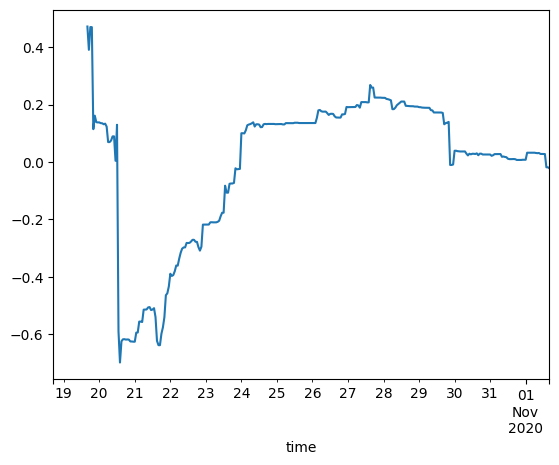

In [13]:
df_imbalance = df_trades.resample(on="time", rule="1h").agg(
    net_position = ("qty_sign", "sum"),
    abs_volume = ("qty_abs", "sum")
)

imbalance_ratio = (
    df_imbalance["net_position"].rolling(window="30d", min_periods=24).sum()
 ) / df_imbalance["abs_volume"].rolling(window="30d", min_periods=24).sum()

imbalance_ratio.plot()

In [14]:
imbalance_ratio.mean()

-0.005836979818238573